In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load Data and Define Inputs
# -----------------------------
df = pd.read_csv("/content/updated_file_drop_color_intensity.csv")

# Define your tabular feature columns (update as needed)

target_columns = ["clarity", "cut","shape"]
image_column = "Image id"


feature_columns = [col for col in df.columns if col not in target_columns + [image_column]]

X_tab = df[feature_columns]

X_tab.head()

,Contrast,Homogeneity,Energy,Correlation,Edge_Density,Intensity_Variance,Hue_Std,Saturation_Std,Aspect_Ratio,Perimeter,Area,Circularity,Convexity,Edge_Sharpness,Symmetry
0,3.261303,0.888582,0.749260,0.995556,2.170091,750.484431,47.795822,63.518461,1.002882,1373.254833,117885.0,0.785536,0.993444,22.581386,0.972512
1,8.984511,0.844536,0.772806,0.995882,5.503750,3341.218207,34.060722,25.861783,0.656780,1293.124012,105705.5,0.794378,0.995606,43.235618,0.925087
2,10.969107,0.845418,0.791677,0.995696,8.323262,4394.860524,45.950897,12.087048,0.623529,306.676186,1695.0,0.226475,0.662368,135.527886,0.926447
3,12.973305,0.850540,0.797043,0.989103,7.084543,2284.820490,43.158840,24.812120,1.092697,1175.928057,727.0,0.000475,0.007589,226.929642,0.935908
4,8.719243,0.873483,0.814791,0.996255,6.012195,3506.119206,39.389006,16.391353,1.935484,239.965510,501.0,0.109333,0.442971,106.968626,0.945912


In [ ]:
image_paths = df['Image id']

In [ ]:
import pickle
from sklearn.preprocessing import OneHotEncoder

# Initialize encoders
encoder_clarity = OneHotEncoder(sparse_output=False)
encoder_cut = OneHotEncoder(sparse_output=False)
encoder_shape = OneHotEncoder(sparse_output=False)

# Fit and transform
y_clarity = encoder_clarity.fit_transform(df[[target_columns[0]]])
y_cut = encoder_cut.fit_transform(df[[target_columns[1]]])
y_shape = encoder_shape.fit_transform(df[[target_columns[2]]])

# Save encoders for later use
with open('encoders.pkl', 'wb') as f:
    pickle.dump({
        'clarity': encoder_clarity,
        'cut': encoder_cut,
        'shape': encoder_shape
    }, f)
# -----------------------------
# 2. Split Data (including image paths)
# -----------------------------
# Split into train and temp (test+validation)
X_tab_train, X_tab_temp, img_paths_train, img_paths_temp, \
    y_clarity_train, y_clarity_temp, y_cut_train, y_cut_temp , y_shape_train , y_shape_temp = train_test_split(
    X_tab, image_paths, y_clarity, y_cut, y_shape, test_size=0.4, random_state=42
)

# Further split temp into validation and test sets
X_tab_val, X_tab_test, img_paths_val, img_paths_test, \
    y_clarity_val, y_clarity_test, y_cut_val, y_cut_test,y_shape_val , y_shape_test  = train_test_split(
    X_tab_temp, img_paths_temp, y_clarity_temp, y_cut_temp, y_shape_temp, test_size=0.5, random_state=42
)

In [ ]:

# Combine tabular features and image paths into a DataFrame
train_df = X_tab_train.copy()
train_df["img_path"] = img_paths_train

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Oversample using y_clarity (to maintain consistency across targets)
train_df_resampled, y_clarity_resampled = ros.fit_resample(train_df, y_clarity_train)

# Extract resampled tabular data and image paths
X_tab_train_resampled = train_df_resampled.drop(columns=["img_path"])  # Remove img_path before training
img_paths_train_resampled = train_df_resampled["img_path"].values

# Get the indices used for resampling
resample_indices = ros.sample_indices_

# Apply the same resampling indices to other target labels

y_cut_resampled = y_cut_train[resample_indices]
y_shape_resampled = y_shape_train[resample_indices]

# Convert targets back to NumPy arrays
y_clarity_resampled = np.array(y_clarity_resampled)
y_cut_resampled = np.array(y_cut_resampled)
y_shape_resampled = np.array(y_shape_resampled)

# print all lengths
print(len(X_tab_train_resampled), len(img_paths_train_resampled),
      len(y_clarity_resampled),
      len(y_cut_resampled), len(y_shape_resampled))

19952 19952 19952 19952 19952


In [ ]:
# -----------------------------
# 3. Preprocess Tabular Data and Load Images
# -----------------------------
# Scale the tabular features
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_val_scaled   = scaler.transform(X_tab_val)
X_tab_test_scaled  = scaler.transform(X_tab_test)

# Define a helper function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Check if the image path exists
    if os.path.exists(image_path):
        # Load and preprocess the image if it exists
        print(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Scale pixel values to [0, 1]
        return img_array / 255.0
    else:
        # If image does not exist, print a warning and return None
        print(f"Warning: {image_path} does not exist. Skipping...")
        return None

# Load images for each split (this may take some time depending on dataset size)
train_images = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_train) if img is not None])
val_images   = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_val) if img is not None])
test_images  = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_test) if img is not None])

In [ ]:
# Convert labels to NumPy arrays (using correct resampled labels)
Y_clarity_train_array = np.array(y_clarity_resampled)
Y_cut_train_array     = np.array(y_cut_resampled)
Y_shape_train_array   = np.array(y_shape_resampled)

Y_clarity_val_array = np.array(y_clarity_val)
Y_cut_val_array     = np.array(y_cut_val)
Y_shape_val_array   = np.array(y_shape_val)

Y_clarity_test_array = np.array(y_clarity_test)
Y_cut_test_array     = np.array(y_cut_test)
Y_shape_test_array   = np.array(y_shape_test)

In [ ]:
# Tabular input
tab_input = keras.Input(shape=(X_tab_train_scaled.shape[1],), name="tab_input")



# MLP branches for clarity, cut, and shape
clarity_branch = layers.Dense(256, activation="linear")(tab_input)
clarity_branch = layers.Dense(512, activation="relu")(clarity_branch)
clarity_branch = layers.Dropout(0.3)(clarity_branch)
clarity_branch = layers.Dense(1024, activation="relu")(clarity_branch)
clarity_branch = layers.Dense(512, activation="linear")(clarity_branch)
clarity_branch = layers.Dropout(0.3)(clarity_branch)
clarity_branch = layers.Dense(256, activation="relu")(clarity_branch)
clarity_branch = layers.Dropout(0.3)(clarity_branch)
clarity_branch = layers.Dense(128, activation="relu")(clarity_branch)
clarity_branch = layers.Dense(64, activation="relu")(clarity_branch)

cut_branch = layers.Dense(256, activation="linear")(tab_input)
cut_branch = layers.Dense(512, activation="relu")(cut_branch)
cut_branch = layers.Dropout(0.3)(cut_branch)
cut_branch = layers.Dense(1024, activation="relu")(cut_branch)
cut_branch = layers.Dense(512, activation="linear")(cut_branch)
cut_branch = layers.Dropout(0.3)(cut_branch)
cut_branch = layers.Dense(256, activation="relu")(cut_branch)
cut_branch = layers.Dropout(0.3)(cut_branch)
cut_branch = layers.Dense(128, activation="relu")(cut_branch)
cut_branch = layers.Dense(64, activation="relu")(cut_branch)

shape_branch = layers.Dense(256, activation="linear")(tab_input)
shape_branch = layers.Dense(512, activation="relu")(shape_branch)
shape_branch = layers.Dropout(0.3)(shape_branch)
shape_branch = layers.Dense(1024, activation="relu")(shape_branch)
shape_branch = layers.Dense(512, activation="linear")(shape_branch)
shape_branch = layers.Dropout(0.3)(shape_branch)
shape_branch = layers.Dense(256, activation="relu")(shape_branch)
shape_branch = layers.Dropout(0.3)(shape_branch)
shape_branch = layers.Dense(128, activation="relu")(shape_branch)
shape_branch = layers.Dense(64, activation="relu")(shape_branch)

# Image (CNN) branch
img_input = keras.Input(shape=(128, 128, 3), name="img_input")
c = layers.Conv2D(32, (3, 3), activation="relu")(img_input)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(64, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(128, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Flatten()(c)
c = layers.Dense(64, activation="relu")(c)






# Combine the MLP branches and CNN branch
combined = layers.concatenate([clarity_branch, cut_branch, shape_branch, c])

# Final Dense layer to combine information
combined = layers.Dense(128, activation="relu")(combined)

# Output layers for multi-output classification
clarity_output = layers.Dense(Y_clarity_train_array.shape[1], activation="softmax", name="clarity")(combined)
cut_output = layers.Dense(Y_cut_train_array.shape[1], activation="softmax", name="cut")(combined)
shape_output = layers.Dense(Y_shape_train_array.shape[1], activation="softmax", name="shape")(combined)

# Define the model with two inputs
model = keras.Model(inputs=[tab_input, img_input],
                    outputs=[clarity_output, cut_output, shape_output])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "clarity": "categorical_crossentropy",
        "cut": "categorical_crossentropy",
        "shape": "categorical_crossentropy"
    },
    metrics={
        "clarity": "accuracy",
        "cut": "accuracy",
        "shape": "accuracy"
    }
)

# Display the model summary
model.summary()


# -----------------------------
# 6. Train the Model
# -----------------------------
history = model.fit(
    [X_tab_train_scaled, train_images],
    {"clarity": Y_clarity_train_array, "cut": Y_cut_train_array, "shape": Y_shape_train_array},
    validation_data=(
        [X_tab_val_scaled, val_images],
        {"clarity": Y_clarity_val_array, "cut": Y_cut_val_array, "shape": Y_shape_val_array}
    ),
    epochs=10,
    batch_size=32,
    verbose=1
)

# -----------------------------
# 7. Evaluate the Model
# -----------------------------
# Predict on the test set
predictions = model.predict([X_tab_test_scaled, test_images])

# Convert probabilities to predicted class indices
Y_test_pred = [np.argmax(pred, axis=1) for pred in predictions]

# Convert one-hot test labels back to class indices
Y_test_true = [
    np.argmax(Y_clarity_test_array, axis=1),
    np.argmax(Y_cut_test_array, axis=1),
    np.argmax(Y_shape_test_array, axis=1)
]

# Print classification reports for each output
for i, name in enumerate(["Clarity", "Cut", "Shape"]):
    print(f"{name} Classification Report:\n", classification_report(Y_test_true[i], Y_test_pred[i]))

# Save the trained model
model.save("picture_model.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tab_input (InputLayer)    │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │          4,096 │ tab_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │          4,096 │ tab_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 256)            │          4,096 │ tab_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        131,584 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 512)            │        131,584 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 512)            │        131,584 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ img_input (InputLayer)    │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 512)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1024)           │        525,312 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1024)           │        525,312 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1024)           │        525,312 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        524,800 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 512)            │        524,800 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 512)            │        524,800 │ dense_17[0][0]         │
├──────────────────────

 Total params: 5,810,526 (22.17 MB)

 Trainable params: 5,810,526 (22.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 146s 222ms/step - clarity_accuracy: 0.5175 - clarity_loss: 0.9968 - cut_accuracy: 0.8551 - cut_loss: 0.5743 - loss: 2.5690 - shape_accuracy: 0.6983 - shape_loss: 0.9980 - val_clarity_accuracy: 0.5375 - val_clarity_loss: 0.9335 - val_cut_accuracy: 0.8896 - val_cut_loss: 0.4658 - val_loss: 2.0591 - val_shape_accuracy: 0.8331 - val_shape_loss: 0.6700
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 139s 223ms/step - clarity_accuracy: 0.6860 - clarity_loss: 0.6685 - cut_accuracy: 0.9429 - cut_loss: 0.2199 - loss: 1.1957 - shape_accuracy: 0.9199 - shape_loss: 0.3073 - val_clarity_accuracy: 0.4359 - val_clarity_loss: 1.0796 - val_cut_accuracy: 0.8956 - val_cut_loss: 0.4286 - val_loss: 2.1530 - val_shape_accuracy: 0.8402 - val_shape_loss: 0.6607
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 138s 221ms/step - clarity_accuracy: 0.7845 - clarity_loss: 0.4811 - cut_accuracy: 0.9654 - cut_loss: 0.1373 - loss: 0.8069 - shape_accuracy: 0.9523 - shape_loss: 0.1885 - val_clari

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Clarity Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.36      0.35       581
           1       0.12      0.20      0.15         5
           2       0.15      0.13      0.14       250
           3       0.69      0.69      0.69      1675

    accuracy                           0.56      2511
   macro avg       0.33      0.34      0.33      2511
weighted avg       0.55      0.56      0.55      2511

Cut Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70       103
           1       0.25      0.08      0.12        13
           3       0.80      0.66      0.72       246
           4       0.00      0.00      0.00         5
           5       0.33      0.09      0.14        11
           7       0.92      0.98      0.95      1889
           8       0.00      0.00      0.00         9
           9       0.81      0.77      0.79        22
          10      

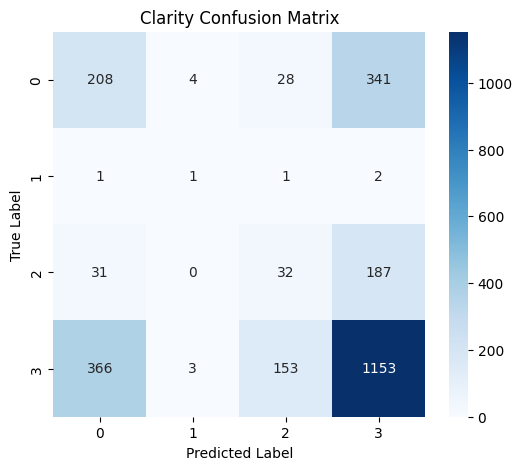

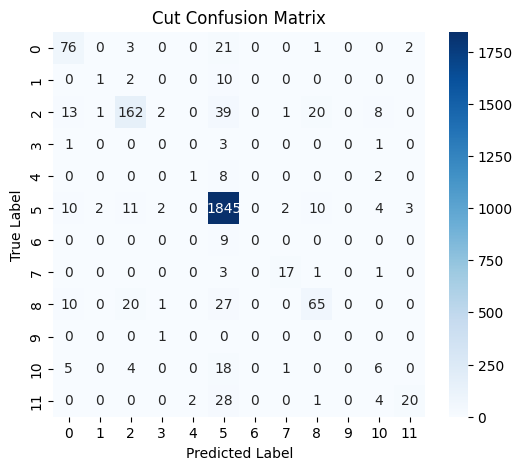

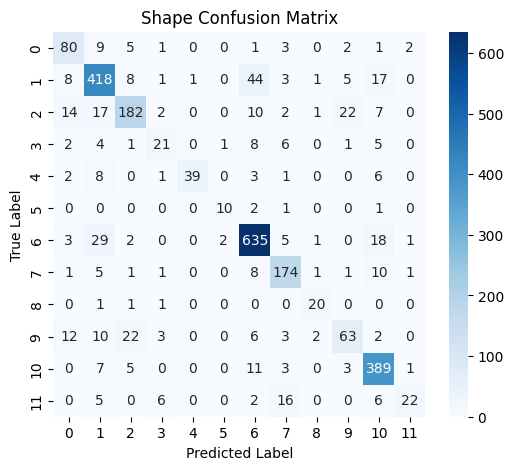

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate and plot confusion matrices for each classification output
for i, name in enumerate(["Clarity", "Cut", "Shape"]):
    cm = confusion_matrix(Y_test_true[i], Y_test_pred[i])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
